# Import the necessary libraries, dataset



In [1]:
# Buiding a NN model
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [10]:
!pip install torchsummary


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# 1. Data Preparation
# Simple neural network to predict the delivery time using distance
distances = torch.tensor([[1.0], [2.0], [3.0], [4.0]], dtype=torch.float32)# 4 examples with single feature

# Delivery times in minutes
times = torch.tensor([[6.96], [12.11],[16.77],[22.21]], dtype=torch.float32)# Truth labels with signle output

# 2. Modelling - Architecture, hyper parameters
# Streamlined version of the connected layer, 1 input, 1 output
model = nn.Sequential(nn.Linear(1,1))

# Define the loss function and optimizer
loss_function = nn.MSELoss() # Uses to tune the parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # How to optimize the parameters

# 3. Training
for epoch in range(500):
    # 0. Reset the optimizer
    optimizer.zero_grad()
    
    # 1. Make predictions
    outputs = model(distances)

    # 2. Calculate the loss
    loss = loss_function(outputs, times)

    # 3. Calculate adjustments
    loss.backward()

    # 4. Update the model parameters
    optimizer.step()

# Inference

with torch.no_grad():
    test_distance = torch.tensor([[25.0]])

SyntaxError: incomplete input (320155085.py, line 35)

In [19]:
for param in model.parameters():
    print(param)  # Prints the tensor values of each parameter

Parameter containing:
tensor([[5.0703]], requires_grad=True)
Parameter containing:
tensor([1.8239], requires_grad=True)


In [2]:
# Doanloading the training ata from open datasets
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

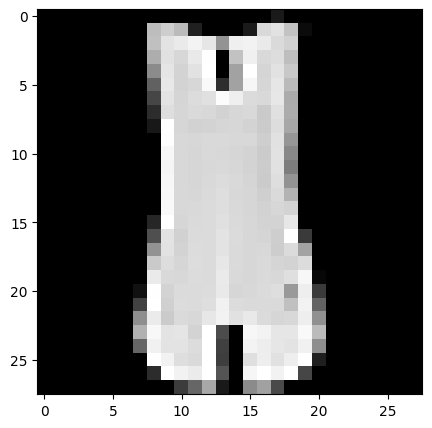

0


In [3]:
# Access the first image with its label
image, label = training_data[4]


%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.imshow(image.squeeze(), cmap = 'gray')
plt.show()
print(label)

In [4]:
# Doanload the test data from open datasets
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

In [5]:
# Define the batch size
batch_size = 64

# Create data loaders

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [6]:
# Creating models
# Accelerator usage
device = torch.accelerator.current_accelerator().type\
if torch.accelerator.is_available() else "cpu"

print("Device: {device}")

Device: {device}


# Define the model architecture

In [7]:
# Define the model

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )
  def forward(self,x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Optimizing the model parameters**

In [8]:
loss_function = nn.CrossEntropyLoss()# Define the loss function which will drive the optimization
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-3)#the optimizer which takes the loss information and updates the weight
# Loss function -> Gradients -> Weights adjustments

# Define the 'Train' method

In [9]:
def train(dataloader, model, loss_function, optimizer):
  size = len(dataloader.dataset)# Size of the training dataset
  model.train()# Train the model
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    prediction = model(X)
    loss = loss_function(prediction, y)

    # Backpropagation
    loss.backward()# Calculate the gradients and attach it to .grad attribute for each parameter
    optimizer.step()# Optimizer has access to params # Update the weights of the model
    optimizer.zero_grad()# Reset the gradients to 0 so the gradients from prev. iteration dont accumulate

    if batch % 100 == 0:
      loss, current = loss.item(), (batch+1)* len(X)
      print(f"loss:{loss:>7f} [{current:>5d}/{size:.>5d}]")


# Define the 'Test' method

In [10]:
def test(dataloader, model, loss_function):
  size = len(dataloader.dataset)
  num_of_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      predictions = model(X)
      test_loss += loss_function(predictions, y).item()
      correct += (predictions.argmax(1) == y). type(torch.float).sum().item()
  test_loss /= num_of_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100* correct):>0.1}%, Avg loss: {test_loss:>8f} \n")


# Train the model

In [11]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1} \n---------")
  train(train_dataloader, model, loss_function, optimizer)
  test(test_dataloader, model, loss_function)
print("Done")

Epoch 1 
---------


loss:2.306156 [   64/60000]
loss:2.294207 [ 6464/60000]
loss:2.271687 [12864/60000]
loss:2.265670 [19264/60000]
loss:2.252181 [25664/60000]
loss:2.227238 [32064/60000]
loss:2.232957 [38464/60000]
loss:2.203803 [44864/60000]
loss:2.196992 [51264/60000]
loss:2.174772 [57664/60000]
Test Error: 
 Accuracy: 4e+01%, Avg loss: 2.165463 

Epoch 2 
---------
loss:2.176948 [   64/60000]
loss:2.171444 [ 6464/60000]
loss:2.109101 [12864/60000]
loss:2.123826 [19264/60000]
loss:2.080888 [25664/60000]
loss:2.025473 [32064/60000]
loss:2.042127 [38464/60000]
loss:1.970429 [44864/60000]
loss:1.970824 [51264/60000]
loss:1.906743 [57664/60000]
Test Error: 
 Accuracy: 6e+01%, Avg loss: 1.905416 

Epoch 3 
---------
loss:1.937409 [   64/60000]
loss:1.915263 [ 6464/60000]
loss:1.791272 [12864/60000]
loss:1.826277 [19264/60000]
loss:1.723569 [25664/60000]
loss:1.675596 [32064/60000]
loss:1.682092 [38464/60000]
loss:1.592382 [44864/60000]
loss:1.609545 [51264/60000]
loss:1.509313 [57664/60000]
Test Error: 
 A

# Save the trained model

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch model state to model.pth")

Saved PyTorch model state to model.pth


# Load the Pre-trained model

In [13]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only = True))

<All keys matched successfully>

# Make the predictions on the new data

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
